In [29]:
include( ("../src/UsefulFunctions.jl" ))
using SparseArrays
using SuiteSparse
using LinearAlgebra
using Plots
exmat(n) = sprand(n,n,3/n)+5I(n);
#f(n) = recInv(sprand(n,n,3/n)+5I)
Φ = 0.2001;
Φ = 0.0
H(n) = sparse(Tridiagonal(exp(im*Φ)*ones(4*n-1),2*ComplexF64.(ones(4*n)),exp(-im*Φ)*ones(4*n-1)))
f(n) = PartialRecInvGr(H(n), 4, "transport");
g(n) = inv(Array((sparse(SymTridiagonal(-2*ones(n),ones(n-1))))));

In [30]:
function b(row::Int,B::Int=4)
    return ((row-1)*B+1):(row*B)
end

function buildM!(Mrows::Vector{Int},Mcols::Vector{Int},elems::Vector{ComplexF64}, rows::UnitRange{Int},cols::UnitRange{Int},submat)
    offsetrow = rows[1]; offsetcol = cols[1]
    for row in rows
        for col in cols
            push!(Mrows,row); push!(Mcols,col)
            push!(elems,submat[row-offsetrow+1,col-offsetcol+1])
        end
    end
end    

function labeldisplay(submat, label::String)
    println("$label:")
    display(submat)
end

function exterior(gʳp::Matrix, V::SparseMatrixCSC, Gʳprev::Matrix)
    return transpose(gʳp*V*transpose(Gʳprev))
end
    
function PartialRecInvGr(M::SparseMatrixCSC, B::Int=4, offdiag = true)
    n = size(M)[1];
    nBs = Int(n/B) # number of diagonal blocks
    LCblocks = Matrix[] # go down the diagonal from left
    RCblocks = Matrix[] # go down the diagonal from right 
    # see Gerhardt Klimeck's powerpoint
    function truth(row::Int, col::Int, mat, label::String)
        println("Partial Gʳ= $label")
        display(mat)
        println("Correct Gʳ block:")
        correct = inv(Array(M))[b(row,B),b(col,B)]
        display(correct)
        #println("Correction real*false^-1:")
        #display(inv(correct)*correct)
    end
    Minv = spzeros(ComplexF64,n,n)
    rows = Int[]; cols = Int[]; elems = ComplexF64[];
    gʳL₀ = inv(Array(M[1:B,1:B]))
    push!(LCblocks,gʳL₀)
    for ib = 2:nBs
        gʳLprior = LCblocks[ib-1]
        # off-diagonal block coupling hamiltonian
        V = M[b(ib-1,B),b(ib,B)]
        #display(V)
        # on-diagonal block hamiltonian
        Dᵢ = M[b(ib,B),b(ib,B)]
        # effective surface green's function including this point
        gʳLᵢ = inv(Array(Dᵢ - V'*gʳLprior*V))
        push!(LCblocks,copy(gʳLᵢ))
    end
    # now we will go back up the diagonal and incorporate coupling from right
    Gʳend = last(LCblocks)
    Gʳᵢ = Gʳend
    buildM!(rows,cols,elems,b(nBs,B),b(nBs,B),Gʳend)
    Gʳplus = copy(Gʳend)
    if offdiag == "legacy"
        for ib = reverse(1:(nBs-1))
            gʳLᵢ = LCblocks[ib]
            # off-diagonal block coupling hamiltonian
            V = M[b(ib,B),b(ib+1,B)]
            # see Klimeck's pwpt
            Gʳᵢ = gʳLᵢ'*(I(B) + V*Gʳplus*V'*gʳLᵢ)
            # add one extra diagonal
            Gʳᵢoffdiag = Array(-gʳLᵢ*V'*Gʳplus)
            buildM!(rows,cols,elems,b(ib+1,B),b(ib,B),transpose(Gʳᵢoffdiag))
            buildM!(rows,cols,elems,b(ib,B),b(ib+1,B),Gʳᵢoffdiag)
            # now do the block-diagonal Gʳ
            buildM!(rows,cols,elems,b(ib,B),b(ib,B),Array(Gʳᵢ))
            Gʳplus = copy(Gʳᵢ)
        end
    elseif offdiag == "transport"
        # go back up the diagonal and also do bottom row
        Gʳbotplus = copy(Gʳend)
        for ib = reverse(1:(nBs-1))
            gʳLᵢ = LCblocks[ib]
            # off-diagonal block coupling hamiltonian
            V = M[b(ib,B),b(ib+1,B)]
            # see Klimeck's pwpt
            # now do the block-diagonal Gʳ
            Gʳᵢ = gʳLᵢ*(I(B) + V*Gʳplus*V'*gʳLᵢ)
            #Atruth(ib,ib,Gʳᵢ,"diagonal subblock")
            buildM!(rows,cols,elems,b(ib,B),b(ib,B),Array(Gʳᵢ));
            Gʳᵢbot = exterior(gʳLᵢ,V,Gʳbotplus)
            #truth(nBs,ib,Gʳᵢbot,"offdiagonal block")
            #Gʳᵢbot = transpose(-gʳLᵢ*conj.(V)*transpose(Gʳbotplus))
            buildM!(rows,cols,elems,b(nBs,B),b(ib,B),Gʳᵢbot)
            Gʳplus = copy(Gʳᵢ)
            Gʳbotplus = copy(Gʳᵢbot)
        end
        # generate the right-connected gʳs
        gʳR₀ = inv(Array(M[b(nBs,B),b(nBs,B)]))
        push!(RCblocks,copy(gʳR₀))
        gʳRprior = gʳR₀
        for ib = reverse(1:(nBs-1))
            # off-diagonal block coupling hamiltonian
            V = M[b(ib,B),b(ib+1,B)]
            #display(V)+
            # on-diagonal block hamiltonian
            Dᵢ = M[b(ib,B),b(ib,B)]
            # effective surface green's function including this point
            gʳRᵢ = inv(Array(Dᵢ - V*gʳRprior*V'))
            push!(RCblocks,copy(gʳRᵢ))
            gʳRprior = gʳRᵢ
        end
        # and now do the top row
        reverse!(RCblocks)
        Gʳtopmin = Gʳᵢ
        for ib = 2:nBs
            gʳRᵢ = RCblocks[ib]
            V = M[b(ib,B),b(ib-1,B)]
            Gʳᵢtop = exterior(gʳRᵢ,V,Gʳtopmin)
            #Gʳᵢtop = -transpose(gʳRᵢ*conj.(V)*transpose(Gʳtopmin))
            buildM!(rows,cols,elems,b(1,B),b(ib,B),Gʳᵢtop)
            Gʳtopmin = copy(Gʳᵢtop)
        end
    else # or for case without the off-diagonal blocks
        for ib = reverse(1:(nBs-1))
            gʳLᵢ = LCblocks[ib]
            # off-diagonal block coupling hamiltonian
            V = M[b(ib,B),b(ib+1,B)]
            # see Klimeck's pwpt
            Gʳᵢ = gʳLᵢ*(I(B) + V*Gʳplus*V'*gʳLᵢ)
            buildM!(rows,cols,elems,b(ib,B),b(ib,B),Array(Gʳᵢ))
            Gʳplus = copy(Gʳᵢ)
        end
    end
    return sparse(rows,cols,elems)
end

PartialRecInvGr (generic function with 3 methods)

In [31]:
E = 1; N = 3; η = 0.001
pGr = Array(PartialRecInvGr((E+im*η)*I(4*N) - H(N),2,"transport"));
#fGr = inv(Array((E+im*η)*I(4*N) - H(N)));
#display(pGr); display(fGr);
#exp(im*0.010001)

In [23]:
timef(n) = @elapsed f(n);
timeg(n) = @elapsed g(n);

In [24]:
nvals = collect(16:32:(2^11));

In [25]:
N = 4
tGʳ(n) = PartialRecInvGr(H(n), 4, "transport");
dGʳ(n) = PartialRecInvGr(H(n), 4, "DOS");
function avgtime(f,nvals) 
    timef(n) = @elapsed f(n) 
    return 1/N * sum([timef.(nvals) for i = 1:N])
end

avgtime (generic function with 1 method)

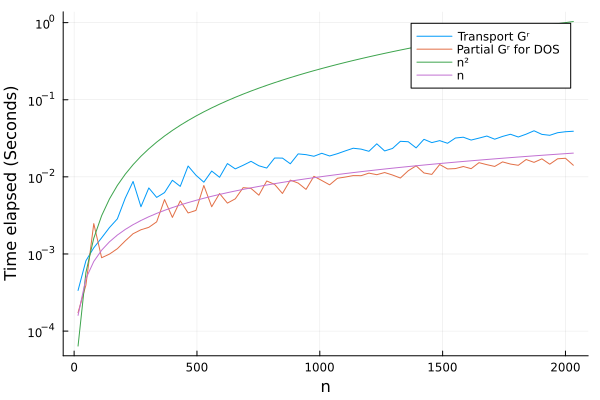

In [26]:
plot(nvals, avgtime(tGʳ,nvals), xlabel="n",ylabel="Time elapsed (Seconds)",yscale=:log10,label="Transport Gʳ")
#plot!(nvals,tvalsg, label="Full Inverse")
plot!(nvals,avgtime(dGʳ,nvals),label="Partial Gʳ for DOS")
plot!(nvals,nvals.^2/4E6,label="n²")
plot!(nvals,nvals/1E5,label="n")

In [27]:
N = 16
PartialRecInvGr((0+im*0.1)*I(4*N) - H(N),4,"transport")

64×64 SparseMatrixCSC{ComplexF64, Int64} with 736 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

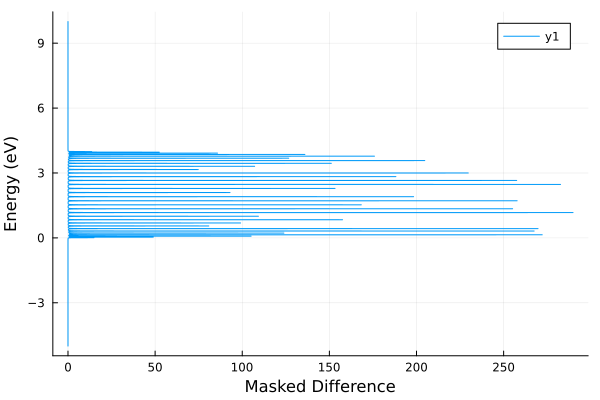

In [32]:
N = 8
E = LinRange(-5,10,5000)
function maskDif(E) 
    pGr = PartialRecInvGr((E+im*η)*I(4*N) - H(N),4,"transport");
    fGr = inv(Array((E+im*η)*I(4*N) - H(N)))
    #display(pGr); display(fGr)
    return sum(abs.(abs.(pGr).*(pGr - fGr)))/(4*N)^2
    #return sum(abs.(pGr.*pGr-pGr.*fGr))
end

plot(maskDif.(E),E, xlabel = "Masked Difference", ylabel = "Energy (eV)")

In [11]:
Gʳbot0 = -3.599783411950253e-5 - 0.007999676016601115im
gʳL = -0.43749967187436334 - 125.00153124392969im
V = -0.9999499003683344 + 0.010009832833670672im
correct = -0.9999859801217741 - 0.002010153186200507im
wrong = transpose(-gʳL*conj.(V)*transpose(Gʳbot0))
d(n) = mod(angle(n)*180/π,360)

labeldisplay(gʳL,"gʳL")
labeldisplay(d(gʳL),"")
labeldisplay(V,"V")
labeldisplay(d(V),"")
labeldisplay(Gʳbot0,"Grbot")
labeldisplay(d(Gʳbot0),"")
labeldisplay(wrong,"wrong Gr")
labeldisplay(d(wrong),"wrong Gr")
labeldisplay(correct,"correct Gr")
labeldisplay(d(correct),"correct Gr")

gʳL:


-0.43749967187436334 - 125.00153124392969im

:


269.79946819743503

V:


-0.9999499003683344 + 0.010009832833670672im

:


179.42646924707407

Grbot:


-3.599783411950253e-5 - 0.007999676016601115im

:


269.7421758029876

wrong Gr:


-0.9999859801217746 - 0.002010153186200515im

wrong Gr:


180.11517475334858

correct Gr:


-0.9999859801217741 - 0.002010153186200507im

correct Gr:


180.11517475334858